This notebook is simulation of pumping test conducted in ssma 2020. The simulation is in confined, one layer regional model. 

Import libraries

In [1]:
import flopy
import pathlib as pl
import glob
from flopy.utils import GridIntersect, Raster
from shapely.geometry import Polygon, Point

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio as rio
import scipy.interpolate
import os
import flopy.utils.binaryfile as bf

Check version

In [2]:
flopy.__version__

'3.8.0'

Load packages

In [3]:
sim = flopy.mf6.MFSimulation.load(
    sim_name='mf6',
    exe_name = 'mf6.exe',
    sim_ws = '.',
    strict=True,
    verbosity_level=1,
    load_only=None,
    verify_data=True,
    write_headers=True,
    lazy_io=False,
    use_pandas=True,
)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disu...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package riv...
    loading package ghb...
  loading solution package mf6model...
Checking model "mf6model"...

mf6model MODEL DATA VALIDATION SUMMARY:
  No errors or warnings encountered.

  Checks that passed:
    npf package: zero or negative horizontal hydraulic conductivity values
    npf package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    npf package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    chd-1 package: BC indices valid
    chd-1 package: not a number (Nan) entries
    chd-1 package: BC in inactive cells
    riv-1 package: BC indices valid
    riv-1 package: not a number (Nan) entries
    riv-1 package: BC in inactive cells
    ghb-1 package: BC indices valid
    ghb-1 package: not 

Obtain model object from a simulation object

In [4]:
m=sim.get_model()

Set projection system

In [5]:
prj1=('PROJCS["NAD_1927_StatePlane_Wyoming_West_Central_FIPS_4903",'
    'GEOGCS["GCS_North_American_1927",DATUM["D_North_American_1927",'
    'SPHEROID["Clarke_1866",6378206.4,294.9786982]],'
    'PRIMEM["Greenwich",0.0],'
    'UNIT["Degree",0.0174532925199433]],'
    'PROJECTION["Transverse_Mercator"],'
    'PARAMETER["False_Easting",500000.0],'
    'PARAMETER["False_Northing",0.0],'
    'PARAMETER["Central_Meridian",-108.75],'
    'PARAMETER["Scale_Factor",0.9999411764705882],'
    'PARAMETER["Latitude_Of_Origin",40.66666666666666],'
    'UNIT["Foot_US",0.3048006096012192]]'
                            )

Obtain modelgrid from model object

In [6]:
mg=m.modelgrid

Set coordinates

In [7]:
mg.set_coord_info(
    xoff=0.,
    yoff=0.,
    angrot=0.,
    crs=prj1,
)

Plot

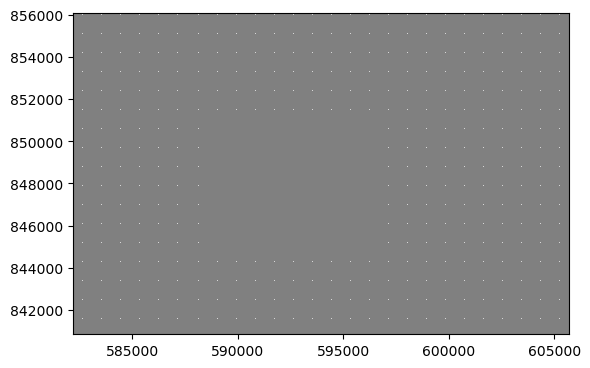

In [8]:
mg.plot()

Bounds

In [9]:
X=mg.get_xvertices_for_layer(0)
Y=mg.get_yvertices_for_layer(0)

In [10]:
xmin=np.min(X)
xmax=np.max(X)
ymin=np.min(Y)
ymax=np.max(Y)
bounds = Polygon([(xmin,ymin),(xmin,ymax),(xmax,ymax),(xmax,ymin),(xmin,ymin)])
xmin,ymin,xmax,ymax
print(bounds)

POLYGON ((582198.1 840855.958, 582198.1 856055.958, 605698.1 856055.958, 605698.1 840855.958, 582198.1 840855.958))


Create geodataframe object from modelgrid

In [11]:
gdf = gpd.GeoDataFrame(data={'geometry':[bounds]},crs=mg.crs)

In [12]:
gdf.explore()

Projection system conversion and plotting well locations-ssma 1000-1012

In [13]:
well_locations = [Point(2062051.69, 906979.12), 
                  Point(2062050.44, 906976.41), 
                  Point(2062049.19, 906973.83),
                  Point(2062049.92, 906968.00),
                  Point(2062051.90, 906972.36),
                  Point(2062053.27, 906975.17),
                  Point(2062054.54, 906977.86), 
                  Point(2062056.37, 906982.51),
                  Point(2062060.97, 906980.41),
                  Point(2062058.99, 906975.91),
                  Point(2062057.78, 906973.18),
                  Point(2062056.30, 906970.47),
                  Point(2062054.27, 906965.98)]

In [14]:
pw = gpd.GeoDataFrame(data={'geometry': well_locations}, crs=6618).to_crs(mg.crs)

In [15]:
pw.explore()

In [16]:
pw

,geometry
0,POINT (593730.641 846267.604)
1,POINT (593729.391 846264.894)
2,POINT (593728.141 846262.314)
3,POINT (593728.871 846256.484)
4,POINT (593730.851 846260.844)
5,POINT (593732.221 846263.654)
6,POINT (593733.491 846266.344)
7,POINT (593735.321 846270.994)
8,POINT (593739.921 846268.894)
9,POINT (593737.941 846264.394)


Intersection of wells with modelgrid to find out cellids (nodes)

In [17]:
results = []
for well in pw.geometry:
  x, y = well.xy
  intersection = mg.intersect(x[0], y[0])  
  results.append(intersection)

print(results)

[414847, 415667, 415667, 415667, 415667, 415667, 414847, 414847, 414848, 415667, 415667, 415667, 416487]


Converting from steady state to transient

In [18]:
tdis = flopy.mf6.ModflowTdis(
    sim,
    pname="tdis",
    time_units="DAYS",
    nper=1,
    perioddata=[(0.16, 100, 1.2)]  
)

In [19]:
sim.tdis.perioddata

{internal}
(rec.array([(0.16, 100, 1.2)],
          dtype=[('perlen', '<f8'), ('nstp', '<i4'), ('tsmult', '<f8')]))

Creating a pandas DataFrame df from the tdis.array data

In [20]:
df= pd.DataFrame.from_records(sim.tdis.perioddata.array)

In [21]:
df = df.iloc[:1]

In [22]:
df

,perlen,nstp,tsmult
0,0.16,100,1.2


In [23]:
sim.tdis

package_name = tdis
filename = mf6.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = mf6

Block options
--------------------
time_units
{internal}
('days')


Block dimensions
--------------------
nper
{internal}
(1)


Block perioddata
--------------------
perioddata
{internal}
(rec.array([(0.16, 100, 1.2)],
          dtype=[('perlen', '<f8'), ('nstp', '<i4'), ('tsmult', '<f8')]))



In [24]:
sim.tdis.perioddata = df.to_records(index=False)

Creating Storage package

In [25]:
sto = flopy.mf6.ModflowGwfsto(m)

Creating wel and obs package for pumping and three monitoring wells

In [26]:
stress_period_data = [
    (415667, -63.5),
]

In [27]:
wel = flopy.mf6.ModflowGwfwel(m, stress_period_data=stress_period_data,)

In [28]:
obsname = ['w1006']  
obstype = ['head']
monitoring_well_cell_ids = [414847]

continuous = list(zip(obsname, obstype, monitoring_well_cell_ids))
obs = flopy.mf6.ModflowUtlobs(m, continuous=continuous)

Updating OC package to show only the last time step

In [29]:
headfile = "mf6_riv_reg.hds"
head_filerecord = [headfile]
budgetfile = f"mf6_riv_reg.cbb"
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "LAST"), ("BUDGET", "LAST")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(
     m,
     saverecord=saverecord,
     head_filerecord=head_filerecord,
     budget_filerecord=budget_filerecord,
     printrecord=printrecord,
)

Create and run simulation

In [30]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package mf6model...
  writing model mf6model...
    writing model name file...
    writing package disu...
    writing package ic...
    writing package npf...
    writing package chd-1...
    writing package riv-1...
    writing package ghb-1...
    writing package sto...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package obs_0...
    writing package oc...


In [31]:
success, buff = sim.run_simulation(
    silent=None,
    pause=False,
    report=False,
    processors=None,
    normal_msg='normal termination',
    use_async=False,
    cargs=None,
    custom_print=None,
)

FloPy is using the following executable to run the model: mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled May 23 2024 18:06:57 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held l

In [32]:
hobj = flopy.utils.HeadFile('mf6_riv_reg.hds', model=m)
hobj.headers

,kstp,kper,pertim,totim,text,ncol,nrow,ilay
52,100,1,0.16,0.16,HEAD,547154,1,1
